#DATASCI W261: Machine Learning at Scale

##Linear regresssion through gradient desecnt method

# Data Generation

Data Information:
+ Sizes: 1000 points
+ True model: y = 1.0 * x - 4
+ Noise：Normal Distributed mean = 0, var = 0.5

In [2]:
 %matplotlib inline
import numpy as np
import pylab 
size = 1000
x = np.random.uniform(-4, 4, size)
y = x * 1.0 - 4 + np.random.normal(0,0.5,size)
data = zip(y,x)
np.savetxt('LinearRegression.csv',data,delimiter = ",")

In [9]:
!head LinearRegression.csv

-4.403619948178061350e+00,-1.534813664042276038e+00
-3.842253534499339374e+00,2.988677936923487266e-01
-4.208312594332259238e+00,-6.066845797987658884e-01
-4.145498824959695128e+00,3.159711562374054594e-01
-4.389961909150479791e+00,-7.068000167724042271e-01
-1.595106195647265079e-01,3.872030030422023650e+00
-2.413823934778789315e+00,1.540179326155935335e+00
-4.742738469612081786e+00,-9.417175779101460975e-01
-9.618217025136650555e-01,2.560654340550422958e+00
-2.185874047833610501e+00,1.788441007891178103e+00


# Data Visualiazation

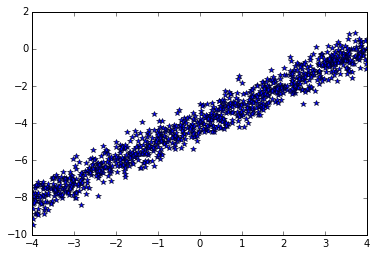

In [10]:
pylab.plot(x, y,'*')
pylab.show()

# MrJob class Code 

Objective function:
$ Q_{ui} = \cases{
r &  if user u rate item i \cr
0 & if user u did not rate item i
} $

In [16]:
%%writefile MrJobBatchGDUpdate_LinearRegression.py
from mrjob.job import MRJob

# This MrJob calculates the gradient of the entire training set 
#     Mapper: calculate partial gradient for each example  
#     
class MrJobBatchGDUpdate_LinearRegression(MRJob):
    # run before the mapper processes any input

    
    #load linear regession model file
    def read_weightsfile(self):
        # Read weights file
        #recordStrs = [s.split('\n')[0].split('\t') for s in open("model").readlines()]
        with open('weights.txt', 'r') as f:
            self.weights = [float(v) for v in f.readline().split(',')]
        # Initialze gradient for this iteration
        self.partial_Gradient = [0]*len(self.weights)
        self.partial_count = 0
    
        
    # MAPPER Calculate partial gradient for each example 
    def partial_gradient(self, _, line):
        D = (map(float,line.split(',')))
        # y_hat is the predicted value given current weights
        y_hat = self.weights[0]+self.weights[1]*D[1]
        # Update parial gradient vector with gradient form current example
        yield None, ((D[0]-y_hat,(D[0]-y_hat)*D[1]),1)
    
  
        
    # REDUCER Accumulate partial gradient from mapper and emit total gradient 
    # Output: key = None, Value = gradient vector
    def gradient_accumulater(self, _, partial_Gradient_Record): 
        total_gradient = [0]*2
        total_count = 0
        for partial_Gradient,partial_count in partial_Gradient_Record:
            total_count = total_count + partial_count
            total_gradient[0] = total_gradient[0] + partial_Gradient[0]
            total_gradient[1] = total_gradient[1] + partial_Gradient[1]
        yield None, [v/total_count for v in total_gradient]
    
    def steps(self):
        return [self.mr(mapper_init=self.read_weightsfile,
                       mapper=self.partial_gradient,
                       #mapper_final=self.partial_gradient_emit,
                       reducer=self.gradient_accumulater)] 
    

    # Calculate partial gradient for each example 
    def partial_gradient_InMemoryCombiner(self, _, line):
        D = (map(float,line.split(',')))
        # y_hat is the predicted value given current weights
        y_hat = self.weights[0]+self.weights[1]*D[1]
        # Update parial gradient vector with gradient form current example
        self.partial_Gradient =  [self.partial_Gradient[0]+ D[0]-y_hat, self.partial_Gradient[1]+(D[0]-y_hat)*D[1]]
        self.partial_count = self.partial_count + 1
        #yield None, (D[0]-y_hat,(D[0]-y_hat)*D[1],1)
    # Finally emit in-memory partial gradient and partial count
    def partial_gradient_emit(self):
        yield None, (self.partial_Gradient,self.partial_count)
        
     
    
    
if __name__ == '__main__':
    MrJobBatchGDUpdate_LinearRegression.run()

Overwriting MrJobBatchGDUpdate_LinearRegression.py


# Driver Code

**Linear regression via gradient descent**
**Objective Function:**
$$ Minimize (\textbf{Y} - \textbf{X}\beta)^2 $$

**Gradient Function:** 
$$ Minimize 2(\textbf{Y} - \textbf{X}\beta)\textbf{X} $$

In [12]:
!pwd 
!ls -l LinearRegression.csv

/Users/z086769/MachineLearning/TargetDataScienceTraining/Week 2
-rw-r--r--  1 z086769  DHC\Domain Users  51453 Jul 13 14:35 LinearRegression.csv


In [13]:
!cat  weights.txt

-1.93530981231,2.51125648201

In [17]:
%reload_ext autoreload
%autoreload 2

from numpy import random,array
from MrJobBatchGDUpdate_LinearRegression import MrJobBatchGDUpdate_LinearRegression

learning_rate = 0.05
stop_criteria = 0.000005

# Generate random values as inital weights
weights = array([random.uniform(-3,3),random.uniform(-3,3)])
# Write the weights to the files
with open('weights.txt', 'w') as f:
    f.writelines(','.join(str(j) for j in weights))

# create a mrjob instance for batch gradient descent update over all data
mr_job = MrJobBatchGDUpdate_LinearRegression(args=['LinearRegression.csv', '--file=weights.txt'])
# Update centroids iteratively
i = 0
while(1):
    print "iteration ="+str(i)+"  weights =",weights
    # Save weights from previous iteration
    weights_old = weights
    with mr_job.make_runner() as runner: 
        runner.run()
        # stream_output: get access of the output 
        for line in runner.stream_output():
            # value is the gradient value
            key,value =  mr_job.parse_output_line(line)
            # Update weights
            weights = weights + learning_rate*array(value)
    i = i + 1
    # Write the updated weights to file 
    with open('weights.txt', 'w') as f:
        f.writelines(','.join(str(j) for j in weights))
    # Stop if weights get converged
    if(sum((weights_old-weights)**2)<stop_criteria):
        break
        
print "Final weights\n"
print weights

iteration =0  weights = [-1.10645841  2.70306298]
iteration =1  weights = [-1.25913938  2.23734124]
iteration =2  weights = [-1.40233824  1.89780844]
iteration =3  weights = [-1.53702982  1.65039978]
iteration =4  weights = [-1.66400507  1.47023998]
iteration =5  weights = [-1.78391666  1.33916459]
iteration =6  weights = [-1.89731253  1.24390985]
iteration =7  weights = [-2.00466062  1.17479078]
iteration =8  weights = [-2.10636703  1.12473581]
iteration =9  weights = [-2.2027895   1.08858189]
iteration =10  weights = [-2.29424738  1.06255958]
iteration =11  weights = [-2.3810291   1.04391718]
iteration =12  weights = [-2.46339776  1.03064611]
iteration =13  weights = [-2.54159532  1.02128048]
iteration =14  weights = [-2.61584584  1.01475061]
iteration =15  weights = [-2.68635793  1.01027618]
iteration =16  weights = [-2.75332665  1.00728809]
iteration =17  weights = [-2.81693508  1.0053715 ]
iteration =18  weights = [-2.87735548  1.00422412]
iteration =19  weights = [-2.93475032  1.

In [12]:
pwd

u'/Users/jshanahan/Dropbox/Projects/Target-2016-04/Classes/Lecture-09-Linear-Regression'

In [13]:
 %matplotlib inline
import numpy as np
import pylab 

size = 1000
x = np.random.uniform(-4, 4, size)
y = x * 1.0 - 4 + np.random.normal(0,0.5,size)
data = zip(y,x)

pylab.plot(x, y,'*')
pylab.show()

NameError: name 'x' is not defined